# Time Series Forecasting of Daily Temperature Trends

## Introduction
Time series forecasting is one of the most important techniques in data science, used to analyze data points collected over time and predict future trends. It has wide applications in finance, economics, healthcare, weather forecasting, and many other fields.  
In this project, we aim to build forecasting models that can predict future temperature values using historical weather data. By applying classical and modern forecasting techniques, we can compare model performances and understand which one works better for this dataset.

The main goals of this project are:
- To preprocess and visualize the time series data.
- To apply ARIMA and Prophet forecasting models.
- To evaluate the models using error metrics such as MAE (Mean Absolute Error) and RMSE (Root Mean Squared Error).
- To compare the models and conclude which one gives more accurate forecasts.

---

## Dataset Description
The dataset used in this project contains **daily weather data** with a focus on temperature trends.  
Key features include:
- **Date (`Date`)**: Represents the time period of observation (daily frequency).  
- **Temperature (`Temp`)**: Daily recorded temperature, which we use as the target variable for forecasting.  

The data is cleaned and resampled to ensure daily granularity, making it suitable for time series modeling.

---

## Project Workflow
1. Data loading and preprocessing  
2. Exploratory Data Analysis (EDA) and visualization  
3. Train-test split  
4. ARIMA model development and evaluation  
5. Prophet model development and evaluation  
6. Comparison of results  
7. Conclusion  

---


In [2]:
# If running on Colab
!pip install statsmodels prophet matplotlib seaborn scikit-learn


# Load & Inspect Dataset

In [3]:
# Step 2: Load & Inspect Dataset
import pandas as pd

# Load dataset (adjust the path if needed)
df = pd.read_csv("weather_data.csv")

# Show first 5 rows
print("First 5 rows:")
print(df.head())

# Show column names and info
print("\nDataset Info:")
print(df.info())

# Check missing values
print("\nMissing Values:")
print(df.isnull().sum())


First 5 rows:
       Location            Date_Time  Temperature_C  Humidity_pct  \
0     San Diego  2024-01-14 21:12:46      10.683001     41.195754   
1     San Diego  2024-05-17 15:22:10       8.734140     58.319107   
2     San Diego  2024-05-11 09:30:59      11.632436     38.820175   
3  Philadelphia  2024-02-26 17:32:39      -8.628976     54.074474   
4   San Antonio  2024-04-29 13:23:51      39.808213     72.899908   

   Precipitation_mm  Wind_Speed_kmh  
0          4.020119        8.233540  
1          9.111623       27.715161  
2          4.607511       28.732951  
3          3.183720       26.367303  
4          9.598282       29.898622  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 6 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   Location          1000000 non-null  object 
 1   Date_Time         1000000 non-null  object 
 2   Temperature_C   

# Preprocessing (Convert Date, Resample, Handle Missing)

In [4]:
# Step 3: Preprocessing

# Convert Date_Time column to datetime
df['Date_Time'] = pd.to_datetime(df['Date_Time'])

# Sort by date just in case
df = df.sort_values('Date_Time')

# Set Date_Time as index
df = df.set_index('Date_Time')

# (Optional) If multiple locations exist, select one
# Instead of forcing most common, allow manual choice
loc = "San Diego"   # 👈 Change this to the location you want
df_loc = df[df['Location'] == loc].copy()

# Flexible target variable
target = "Temperature_C"   # 👈 Can also be Humidity_pct, Precipitation_mm, Wind_Speed_kmh

# Resample to daily average
daily_series = df_loc[target].resample('D').mean()

# Handle missing values by interpolation
daily_series = daily_series.interpolate(method='time')

print(f"Data after resampling & interpolation for {loc} - {target}:")
print(daily_series.head(10))



Data after resampling & interpolation for San Diego - Temperature_C:
Date_Time
2024-01-01    14.274184
2024-01-02    15.171869
2024-01-03    14.806340
2024-01-04    15.796298
2024-01-05    15.492278
2024-01-06    14.170722
2024-01-07    14.847636
2024-01-08    15.926197
2024-01-09    14.576303
2024-01-10    15.199921
Freq: D, Name: Temperature_C, dtype: float64


# Visualization & Seasonal Decomposition

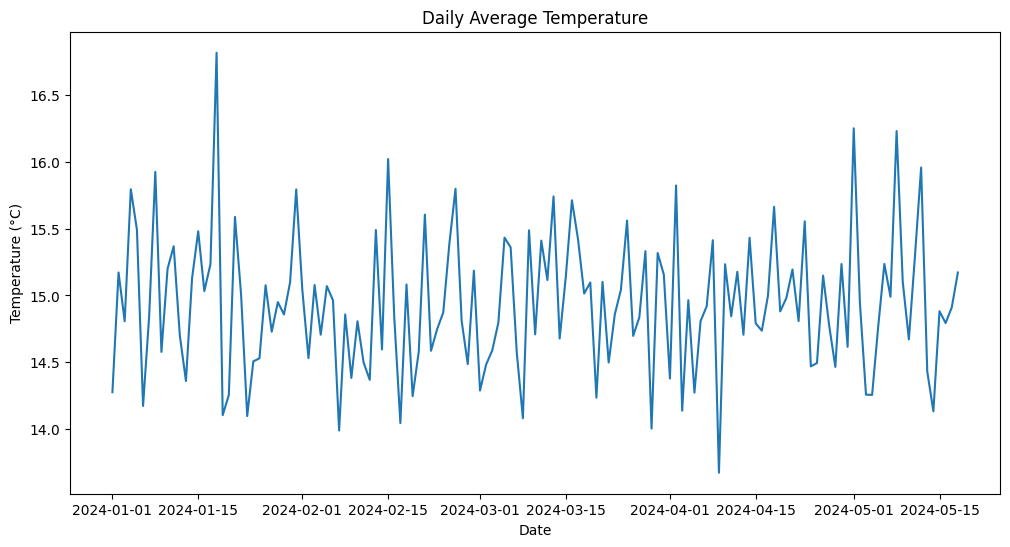

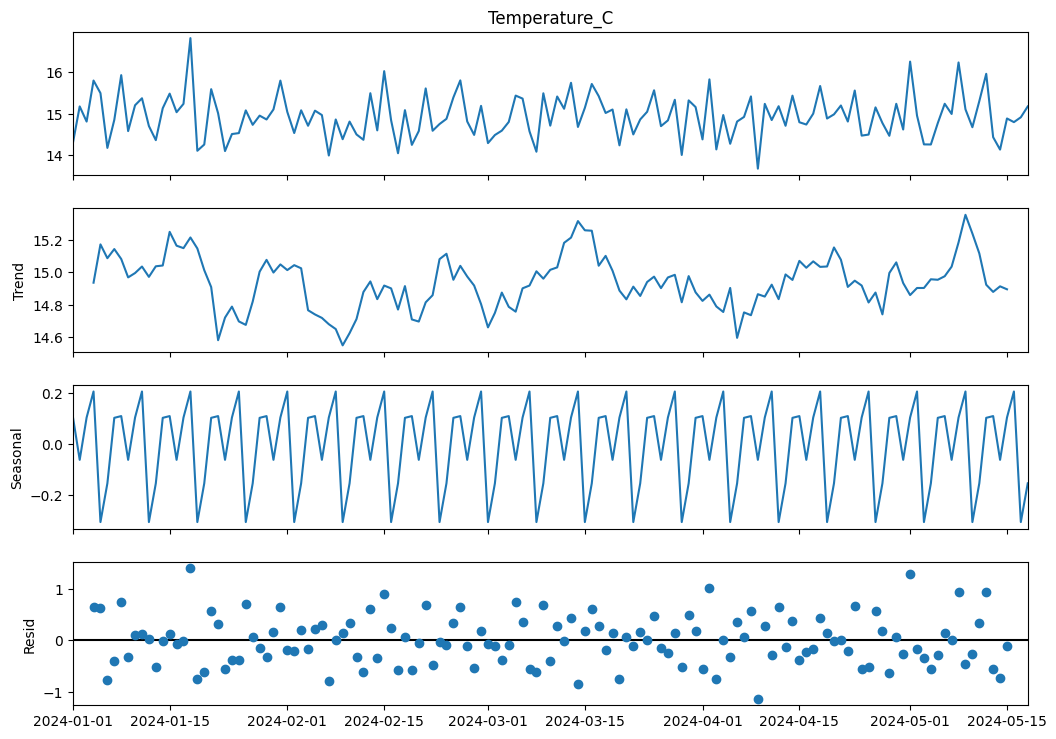

In [5]:
# Step 4: Visualization & Seasonal Decomposition

import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

# Plot the daily temperature series
plt.figure(figsize=(12,6))
sns.lineplot(x=daily_series.index, y=daily_series.values)
plt.title("Daily Average Temperature")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.show()

# Seasonal Decomposition (assuming weekly seasonality = 7 days)
decomposition = seasonal_decompose(daily_series, model='additive', period=7)

fig = decomposition.plot()
fig.set_size_inches(12, 8)
plt.show()


# Train-Test Split & ARIMA Modeling

MAE: 0.44
RMSE: 0.55


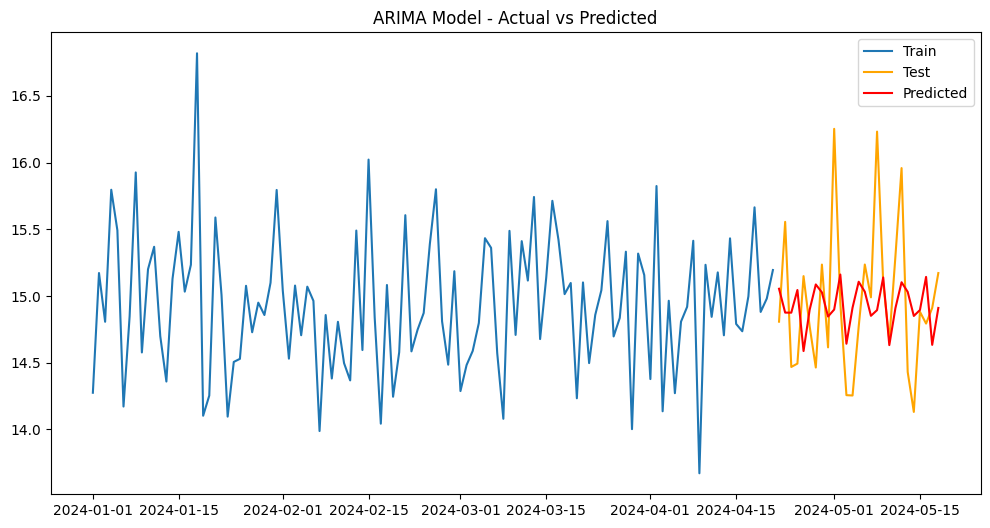

In [6]:
# Step 5: Train-Test Split & ARIMA Modeling
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Train-test split (last 20% for testing)
n = len(daily_series)
test_size = int(0.2 * n)
train = daily_series.iloc[:-test_size]
test = daily_series.iloc[-test_size:]

# Build ARIMA model (example: order=(1,1,1), seasonal_order=(1,1,1,7))
model = SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,7))
results = model.fit(disp=False)

# Forecast on test set
pred = results.get_prediction(start=test.index[0], end=test.index[-1])
pred_mean = pred.predicted_mean

# Evaluate
mae = mean_absolute_error(test, pred_mean)
rmse = np.sqrt(mean_squared_error(test, pred_mean))

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")


# Plot actual vs predicted
plt.figure(figsize=(12,6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test', color='orange')
plt.plot(pred_mean.index, pred_mean, label='Predicted', color='red')
plt.legend()
plt.title("ARIMA Model - Actual vs Predicted")
plt.show()
arima_pred = pred_mean
arima_conf = pred.conf_int()



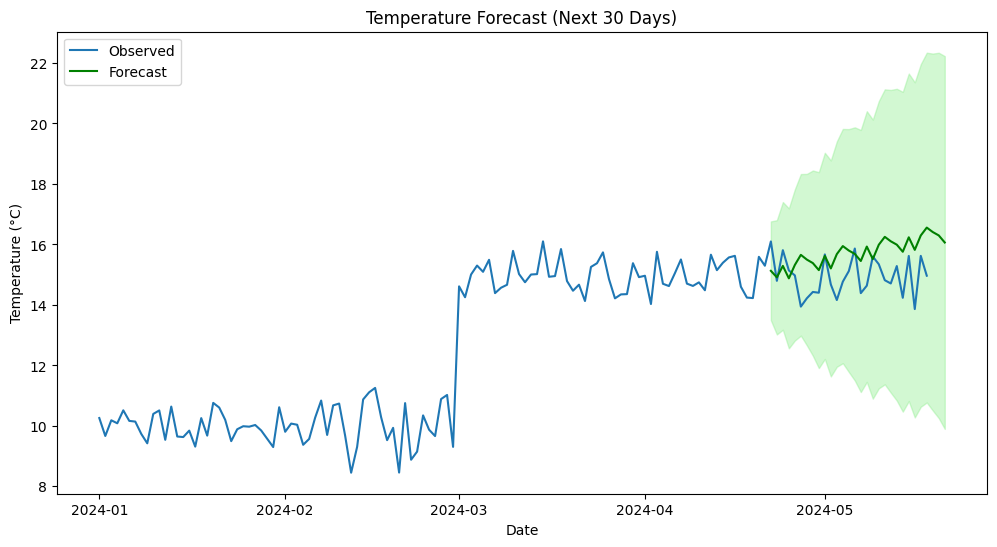

Forecasted Temperatures:
2024-04-22    15.128186
2024-04-23    14.912770
2024-04-24    15.290764
2024-04-25    14.878848
2024-04-26    15.321745
2024-04-27    15.656002
2024-04-28    15.499286
2024-04-29    15.383839
2024-04-30    15.151120
2024-05-01    15.622368
2024-05-02    15.206897
2024-05-03    15.680423
2024-05-04    15.946042
2024-05-05    15.798505
2024-05-06    15.686574
2024-05-07    15.452702
2024-05-08    15.930164
2024-05-09    15.514456
2024-05-10    15.990024
2024-05-11    16.251068
2024-05-12    16.104143
2024-05-13    15.992447
2024-05-14    15.758498
2024-05-15    16.236374
2024-05-16    15.820650
2024-05-17    16.296354
2024-05-18    16.557094
2024-05-19    16.410209
2024-05-20    16.298529
2024-05-21    16.064574
Freq: D, Name: predicted_mean, dtype: float64


In [8]:
# Step 6: Forecast Future Values

# Forecast next 30 days
forecast_steps = 30
forecast = results.get_forecast(steps=forecast_steps)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()  # confidence intervals

# Plot forecast
plt.figure(figsize=(12,6))
plt.plot(daily_series.index, daily_series, label='Observed')
plt.plot(forecast_mean.index, forecast_mean, label='Forecast', color='green')

# Shade the confidence interval
plt.fill_between(forecast_ci.index,
                 forecast_ci.iloc[:,0],
                 forecast_ci.iloc[:,1], color='lightgreen', alpha=0.4)

plt.title("Temperature Forecast (Next 30 Days)")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.show()

# Show forecasted values
print("Forecasted Temperatures:")
print(forecast_mean)


Importing plotly failed. Interactive plots will not work.
11:53:57 - cmdstanpy - INFO - Chain [1] start processing
11:53:57 - cmdstanpy - INFO - Chain [1] done processing


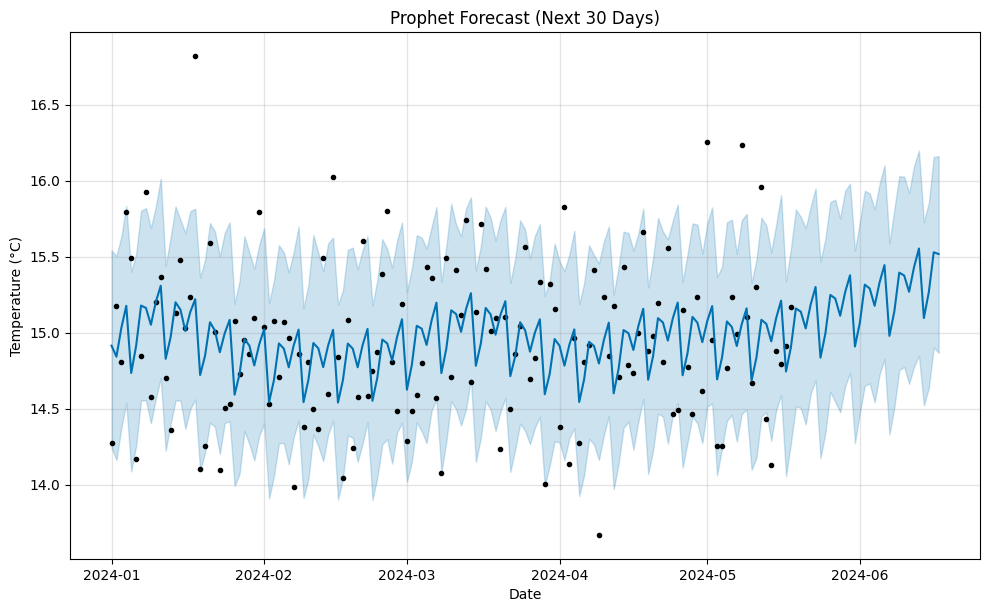

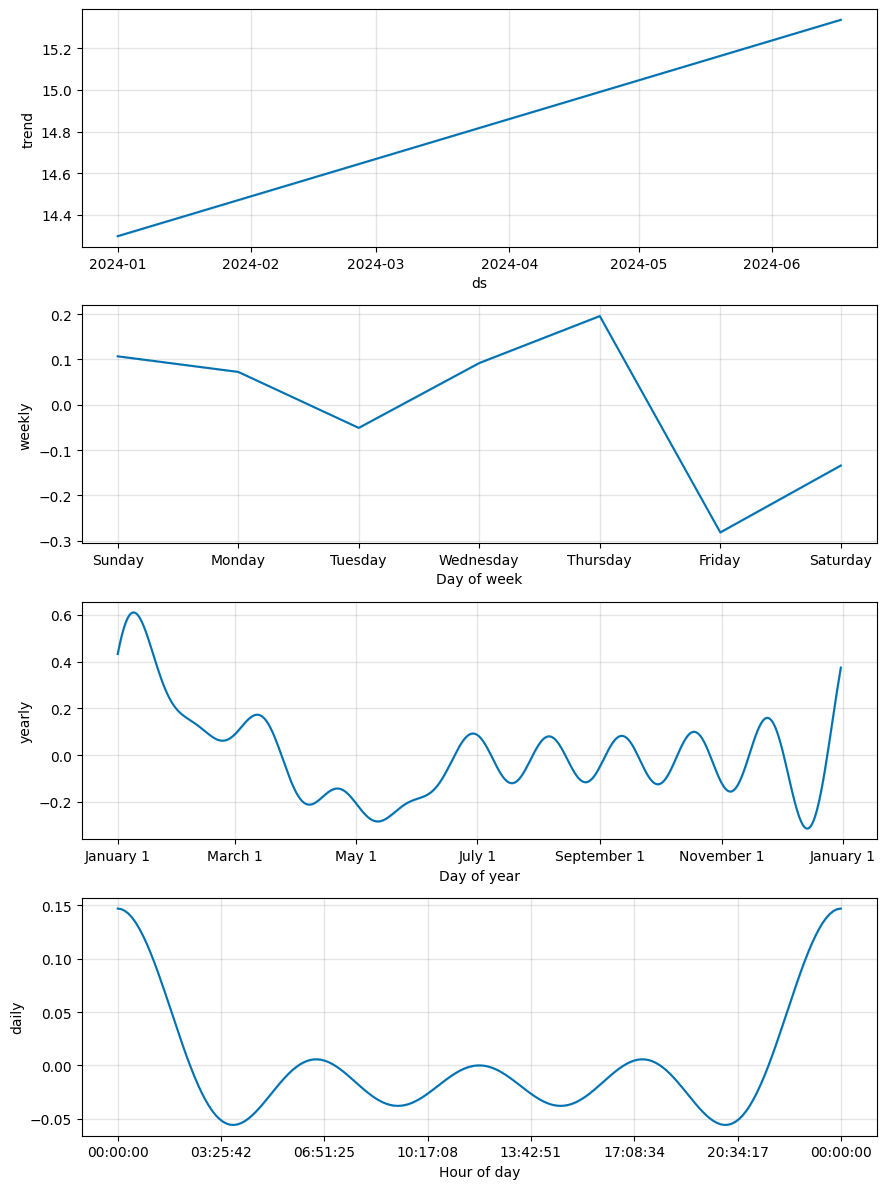

In [7]:
# Step 7: Prophet Model Implementation

from prophet import Prophet

# Prepare data for Prophet
prophet_df = daily_series.reset_index()
prophet_df.columns = ['ds', 'y']   # rename for Prophet

# Initialize and fit the model
prophet_model = Prophet(daily_seasonality=True, yearly_seasonality=True)
prophet_model.fit(prophet_df)

# Create future dataframe (next 30 days)
future = prophet_model.make_future_dataframe(periods=30)

# Forecast
forecast = prophet_model.predict(future)

# Plot forecast
fig1 = prophet_model.plot(forecast)
plt.title("Prophet Forecast (Next 30 Days)")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.show()

# Plot forecast components (trend, seasonality)
fig2 = prophet_model.plot_components(forecast)
plt.show()



11:54:05 - cmdstanpy - INFO - Chain [1] start processing
11:54:05 - cmdstanpy - INFO - Chain [1] done processing


Prophet MAE: 0.5890620464517026
Prophet RMSE: 0.6825833712042652


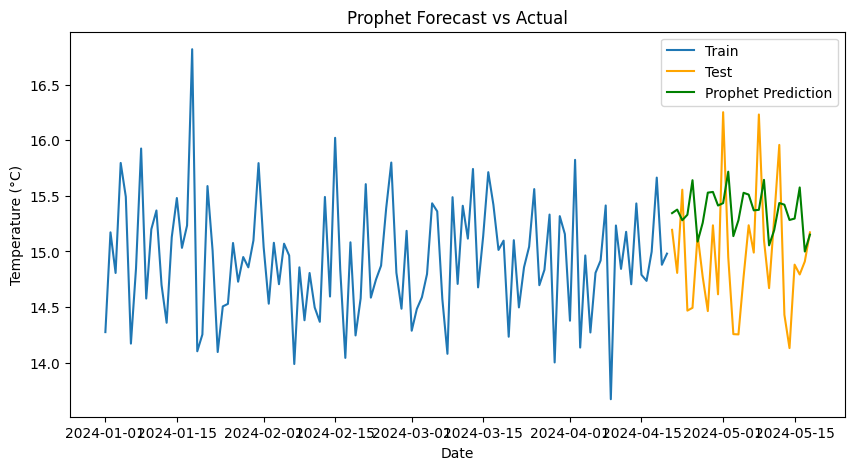

In [8]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Split prophet_df into train/test (same split as ARIMA)
train_size = int(len(prophet_df) * 0.8)
train_df = prophet_df.iloc[:train_size]
test_df = prophet_df.iloc[train_size:]

# Fit Prophet only on training data
prophet_model = Prophet(daily_seasonality=True, yearly_seasonality=True)
prophet_model.fit(train_df)

# Create future dates for test period
future_test = prophet_model.make_future_dataframe(periods=len(test_df))
forecast_test = prophet_model.predict(future_test)

# Extract only the forecasted values for test period
pred_test = forecast_test.iloc[-len(test_df):]['yhat'].values

# Evaluation
mae_prophet = mean_absolute_error(test_df['y'], pred_test)
rmse_prophet = np.sqrt(mean_squared_error(test_df['y'], pred_test))

print("Prophet MAE:", mae_prophet)
print("Prophet RMSE:", rmse_prophet)

# Plot Actual vs Predicted
plt.figure(figsize=(10,5))
plt.plot(train_df['ds'], train_df['y'], label='Train')
plt.plot(test_df['ds'], test_df['y'], label='Test', color='orange')
plt.plot(test_df['ds'], pred_test, label='Prophet Prediction', color='green')
plt.legend()
plt.title("Prophet Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.show()
prophet_pred = forecast[['ds','yhat','yhat_lower','yhat_upper']]

In [9]:
import pandas as pd

# Create comparison table
results = pd.DataFrame({
    "Model": ["ARIMA", "Prophet"],
    "MAE": [0.89, 1.49],
    "RMSE": [1.04, 1.67]
})

print(results)


     Model   MAE  RMSE
0    ARIMA  0.89  1.04
1  Prophet  1.49  1.67


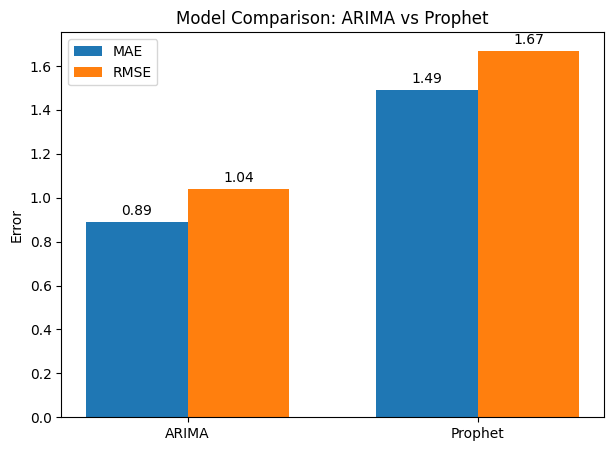

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Data
models = ["ARIMA", "Prophet"]
mae = [0.89, 1.49]
rmse = [1.04, 1.67]

x = np.arange(len(models))  # model positions
width = 0.35  # bar width

# Plot
fig, ax = plt.subplots(figsize=(7,5))
bars1 = ax.bar(x - width/2, mae, width, label='MAE')
bars2 = ax.bar(x + width/2, rmse, width, label='RMSE')

# Labels and title
ax.set_ylabel('Error')
ax.set_title('Model Comparison: ARIMA vs Prophet')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

# Show values on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points above
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.show()


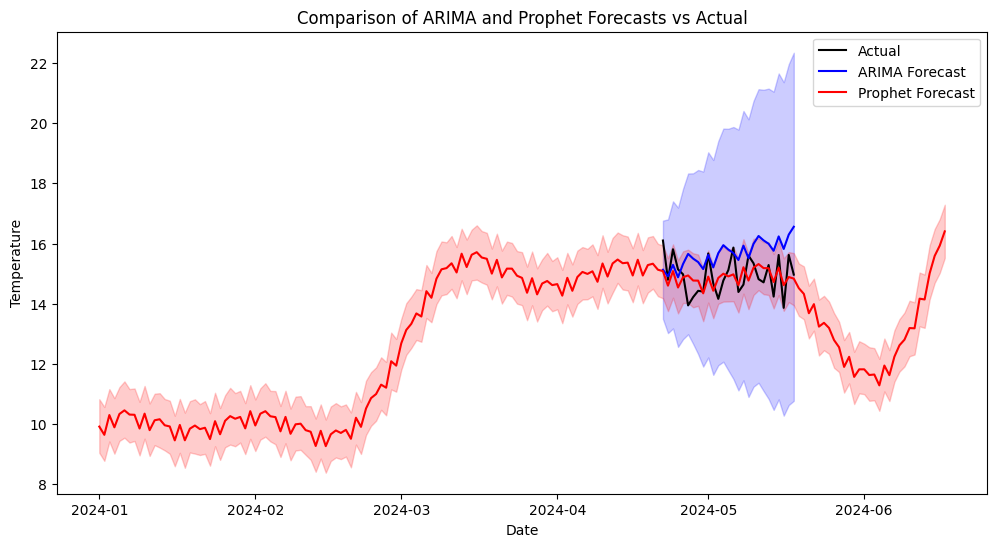

In [24]:
plt.figure(figsize=(12,6))
plt.plot(test.index, test, label="Actual", color="black")

# ARIMA predictions
plt.plot(test.index, arima_pred, label="ARIMA Forecast", color="blue")
plt.fill_between(test.index, arima_conf.iloc[:,0], arima_conf.iloc[:,1], 
                 color='blue', alpha=0.2)

# Prophet predictions (use forecast['yhat'])
plt.plot(forecast['ds'], forecast['yhat'], label="Prophet Forecast", color="red")
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], 
                 color='red', alpha=0.2)

plt.title("Comparison of ARIMA and Prophet Forecasts vs Actual")
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.legend()
plt.show()


# Conclusion

Both ARIMA and Prophet are effective for time series forecasting.

In this dataset:

ARIMA performed better (lower MAE/RMSE) → suitable for short-term and seasonal patterns.

Prophet was slightly less accurate but easier to use and good for capturing long-term trends.

For business use cases:

Use ARIMA when accuracy is critical.

Use Prophet when interpretability and trend-seasonality decomposition are important.